# Séries Temporelles

[![Index](https://img.shields.io/badge/Index-blue)](../index.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/use-cases/time-series.ipynb)

> <span style='color:red'>ATTENTION: notebook en cours d'élaboration!</span>

- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [146]:
from IPython import get_ipython

# Supprimer les commentaires pour installer
# !pip3 install -q -U numpy
# !pip3 install -q -U pandas
# !pip3 install -q -U matplotlib
# !pip3 install -q -U scikit-learn
# !pip3 install -q -U pytrends
# !pip3 install -q -U statsmodels

# À installer dans tous les cas pour Google Colab
if 'google.colab' in str(get_ipython()):
    !pip3 install -q -U skforecast

## Chargement des Données de Google Trends

In [4]:
# Mots clés
k_1 = 'parasol'
k_2 = 'crème solaire'
kw_list=[k_1, k_2]
work_directory = './time-series'

In [28]:
import os
import pandas as pd

if 'google.colab' in str(get_ipython()):
    !curl --create-dirs -O --output-dir ${work_directory} "https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/use-cases/time-series/trend.csv"
if os.path.isfile(f'{work_directory}/trend.csv'):
    df = pd.read_csv(f'{work_directory}/trend.csv', parse_dates=True, index_col='date')
else:
    # Recherche sur Google Trends
    from pytrends.request import TrendReq
    pytrends = TrendReq(hl='fr-FR', tz=15)
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='', gprop='')
    df = pytrends.interest_over_time()
    df.drop(columns=['isPartial'], inplace=True)
    df.to_csv(f'{work_directory}/trend.csv')
df = df.asfreq('MS')
df.head()

,parasol,crème solaire
date,,
2004-01-01,9,0
2004-02-01,8,1
2004-03-01,12,0
2004-04-01,19,1
2004-05-01,17,1


In [26]:
import pandas as pd

# Vérification qu'il n'y a pas de période manquante
(df.index == pd.date_range(start=df.index.min(), end=df.index.max(), freq=df.index.freq)).all()

True

<Axes: xlabel='date'>

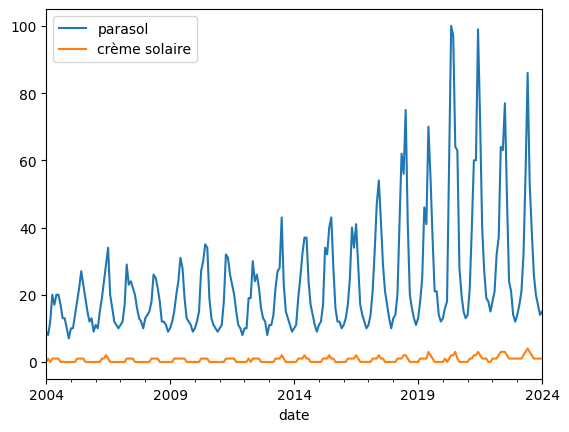

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

# Graphique
df.plot()

## Analyse des Caractéristiques de la Première Série (k_1)

Docs: https://machinelearningmastery.com/time-series-data-stationary-python/

In [124]:
df_1 = df[[k_1]]
df_1.shape

(241, 1)

array([[<Axes: title={'center': 'parasol'}>]], dtype=object)

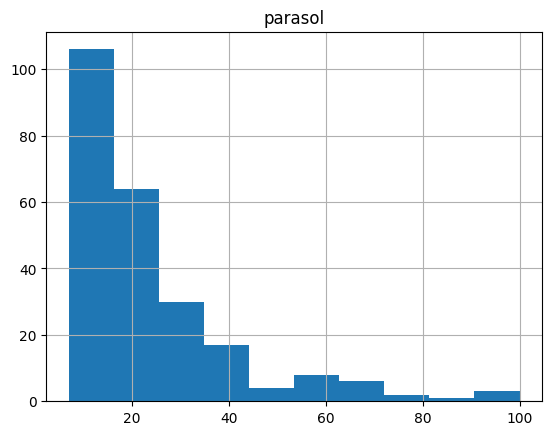

In [225]:
# Ce graphe indique clairement que la distribution des valeurs n'est pas Gaussienne
# et donc que cette série temporelle n'est pas stationnaire 
df_1.hist()
plt.show()

In [243]:
from statsmodels.tsa.stattools import adfuller

def print_adfuller(df):
  result = adfuller(df)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# C'est d'ailleurs confirmé par le test augmenté de Dicker-Fuller 
print_adfuller(df_1)

ADF Statistic: -0.959935
p-value: 0.767595
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


In [253]:
from numpy import log

# Log does not help
print_adfuller(log(df_1))

ADF Statistic: -0.789950
p-value: 0.822056
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [261]:
from statsmodels.tsa.tsatools import detrend

# "Detrend" d'un ordre de 5 rend la série temporelle stationaire au niveau de significance de 1%
order = 5 # essayer 4
df_1_detrend = detrend(df_1, order=order)
print_adfuller(df_1_detrend)

# df_1_trend = df_1 - df_1_detrend
# df_1 = df_1_trend + df_1_detrend

ADF Statistic: -4.145711
p-value: 0.000813
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


In [249]:
# Soustraire la moyenne glissante sur 12 mois est une autre façon de rendre la série temporelle stationaire au niveau de significance de 1%
rolling_mean = df_1[k_1].rolling(window=12, center=True).mean()
print_adfuller((df_1[k_1] - rolling_mean).dropna(inplace=True))

ADF Statistic: -8.033657
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


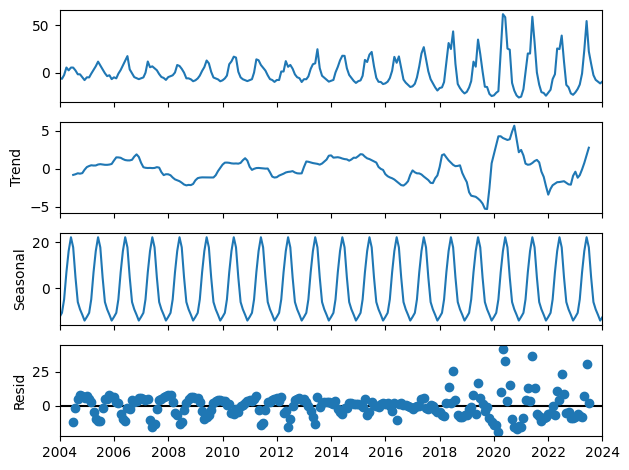

In [262]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_1_detrend, model='additive') # essayer 'multiplicative'
result.plot()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

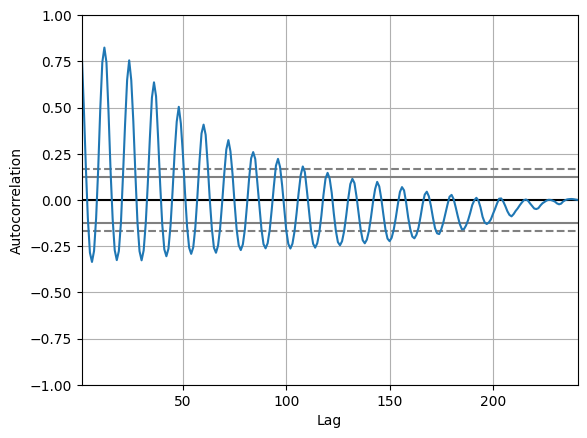

In [126]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_1)
plt.show()

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

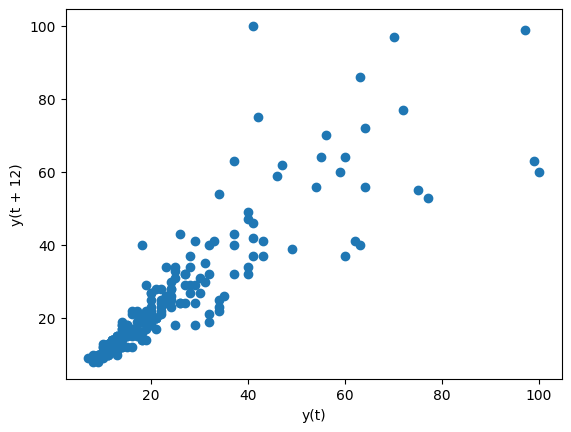

In [127]:
# We can check that there is a 12 month frequency (lag=12)
from pandas.plotting import lag_plot

lag_plot(df_1, lag=12)
plt.show()

## Graphes ACF et PACF

Docs: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

<Figure size 1200x600 with 0 Axes>

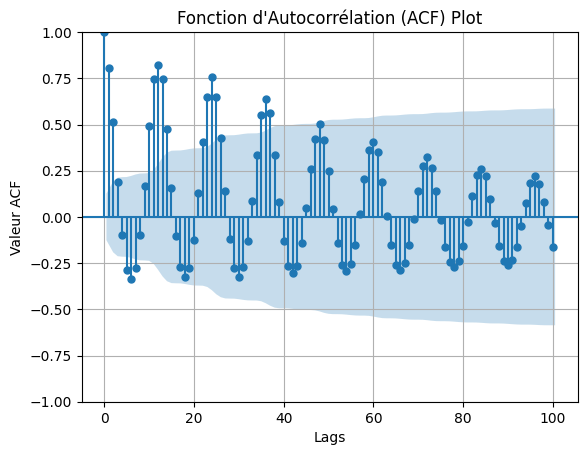

In [223]:
from statsmodels.graphics.tsaplots import plot_acf

# acf_values = sm.tsa.acf(df_1)
plt.figure(figsize=(12,6))
plot_acf(df_1, lags=100) #len(df_1)-1)
plt.title('Fonction d\'Autocorrélation (ACF) Plot')
plt.xlabel('Lags')
plt.ylabel('Valeur ACF')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

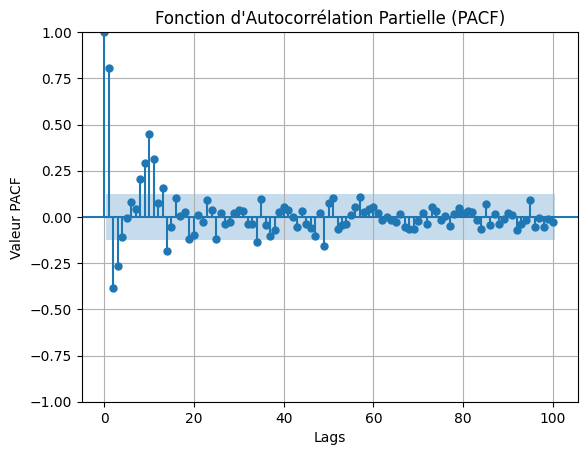

In [224]:
from statsmodels.graphics.tsaplots import plot_pacf

# pacf_values = sm.tsa.pacf(df_1)
plt.figure(figsize=(12,6))
plot_pacf(df_1, lags=100) #len(df_1)-1)
plt.title('Fonction d\'Autocorrélation Partielle (PACF)')
plt.xlabel('Lags')
plt.ylabel('Valeur PACF')
plt.grid(True)
plt.show()

## Création d'un Jeu d'Entraînement et de Test

Docs:
- https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

Total: 241
Entraînement: 193
Test: 48


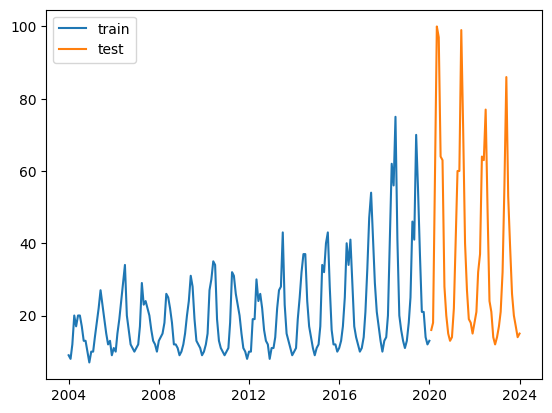

In [144]:
split = round(0.8*len(df_1))
train, test = df_1[0:split], df_1[split:]
print('Total:', len(df_1))
print('Entraînement:', len(train))
print('Test:', len(test))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.show()

## Prédictions avec SciKit-Learn (et skforecast)

In [149]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_state=42

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=random_state),
    lags=12
)

forecaster.fit(y=train[k_1])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2004-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-01-31 13:03:14 
Last fit date: 2024-01-31 13:03:14 
Skforecast version: 0

In [156]:
pred = forecaster.predict(steps=len(test))
pred.head(3)

2020-02-01    19.02
2020-03-01    36.12
2020-04-01    49.18
Freq: MS, Name: pred, dtype: float64

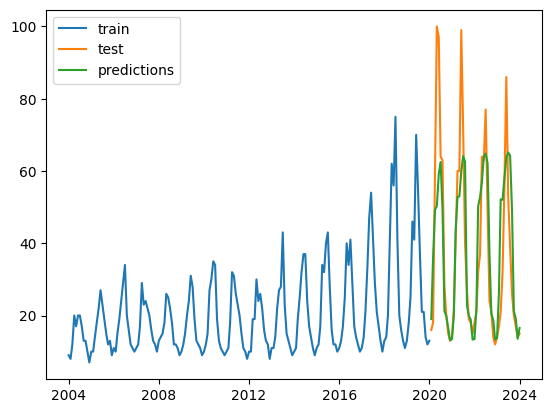

In [157]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

## Prédictions avec StatsModels

### Autorégression (AR)

In [168]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train, lags=12).fit()
pred = model.predict(len(train), len(train)+ len(test))
print(model.summary())
pred.head(3)

                            AutoReg Model Results                             
Dep. Variable:                parasol   No. Observations:                  193
Model:                    AutoReg(12)   Log Likelihood                -522.151
Method:               Conditional MLE   S.D. of innovations              4.331
Date:                Wed, 31 Jan 2024   AIC                           1072.303
Time:                        13:41:30   BIC                           1117.082
Sample:                    01-01-2005   HQIC                          1090.457
                         - 01-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3902      1.420      0.275      0.783      -2.393       3.173
parasol.L1      0.3612      0.073      4.980      0.000       0.219       0.503
parasol.L2      0.1043      0.070      1.486    

2020-02-01    15.928628
2020-03-01    30.989137
2020-04-01    39.515970
Freq: MS, dtype: float64

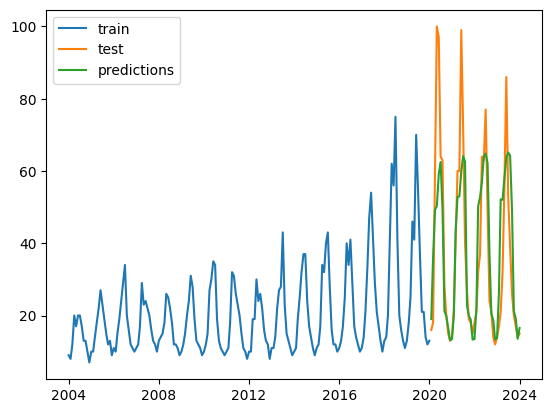

In [158]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

### Moyenne Mobile (MA - Moving Average)

In [202]:
from statsmodels.tsa.arima.model import ARIMA

order = (0, 0, 2) # paramètres (p,d,q) pour la moyenne mobile
model = ARIMA(train, order=order).fit()
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)

                               SARIMAX Results                                
Dep. Variable:                parasol   No. Observations:                  193
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -659.097
Date:                Wed, 31 Jan 2024   AIC                           1326.195
Time:                        14:08:39   BIC                           1339.246
Sample:                    01-01-2004   HQIC                          1331.480
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.2036      1.996     10.124      0.000      16.292      24.115
ma.L1          0.8741      0.061     14.404      0.000       0.755       0.993
ma.L2          0.4494      0.082      5.487      0.0

2020-02-01    17.219229
2020-03-01    19.170353
2020-04-01    20.203646
Freq: MS, Name: predicted_mean, dtype: float64

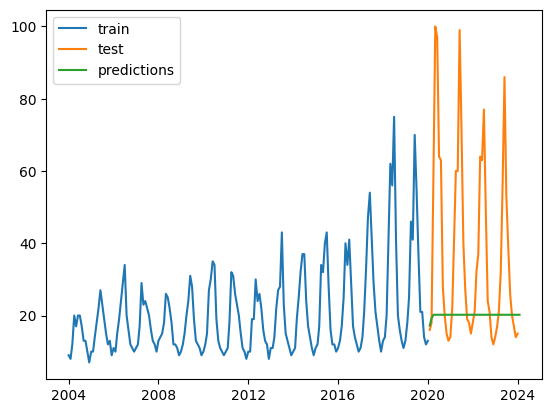

In [203]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

### Moyenne Mobile Autorégressive (ARMA - AutoRegressive Moving Average)

In [174]:
from statsmodels.tsa.arima.model import ARIMA

order = (12, 0, 12) # paramètres (p,d,q) pour la moyenne mobile autorégressive
model = ARIMA(train, order=order).fit()
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                parasol   No. Observations:                  193
Model:               ARIMA(12, 0, 12)   Log Likelihood                -551.081
Date:                Wed, 31 Jan 2024   AIC                           1154.162
Time:                        13:49:41   BIC                           1238.992
Sample:                    01-01-2004   HQIC                          1188.515
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.2669     22.534      0.899      0.368     -23.899      64.433
ar.L1         -0.1420      0.994     -0.143      0.886      -2.091       1.807
ar.L2          0.2560      0.704      0.364      0.7

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2020-02-01    11.276666
2020-03-01    23.887512
2020-04-01    37.933973
Freq: MS, Name: predicted_mean, dtype: float64

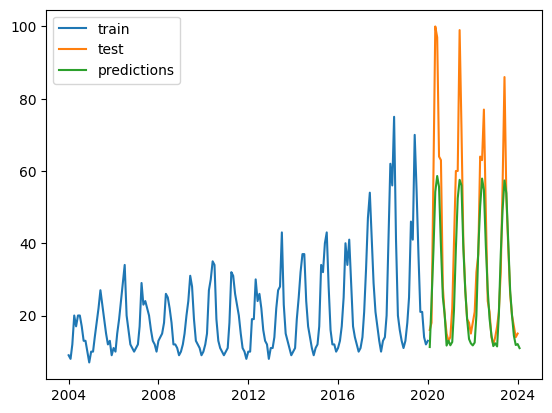

In [175]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

### ARIMA

In [198]:
from statsmodels.tsa.arima.model import ARIMA

order = (1, 1, 1) # paramètres (p,d,q) pour la moyenne mobile autorégressive
model = ARIMA(train, order=order).fit()
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)


                               SARIMAX Results                                
Dep. Variable:                parasol   No. Observations:                  193
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -657.236
Date:                Wed, 31 Jan 2024   AIC                           1320.472
Time:                        14:07:32   BIC                           1330.244
Sample:                    01-01-2004   HQIC                          1324.430
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3983      0.202      1.973      0.049       0.003       0.794
ma.L1         -0.1798      0.206     -0.871      0.384      -0.584       0.225
sigma2        55.0375      3.448     15.963      0.0

2020-02-01    13.085958
2020-03-01    13.120192
2020-04-01    13.133826
Freq: MS, Name: predicted_mean, dtype: float64

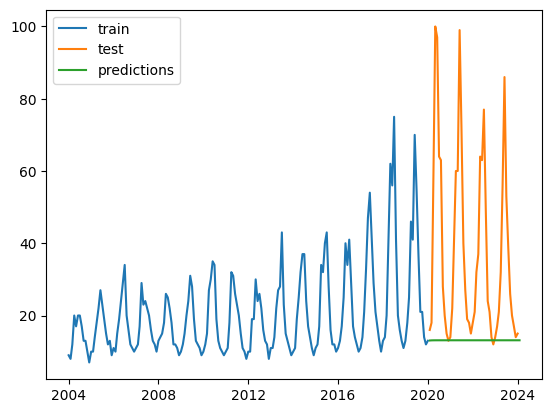

In [199]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

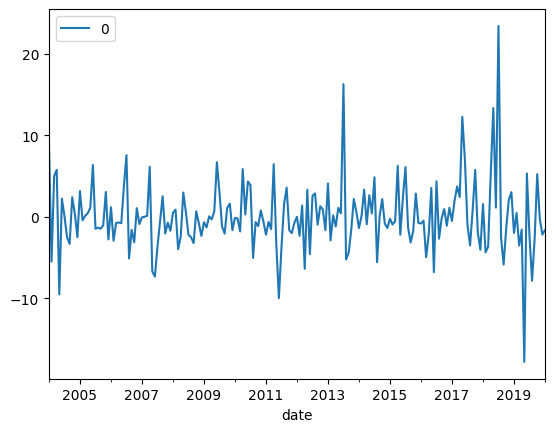

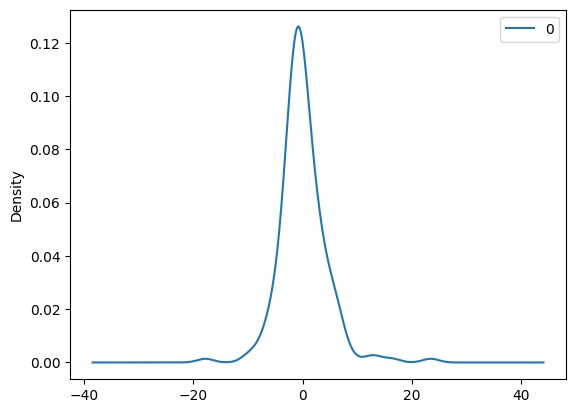

                0
count  193.000000
mean     0.038268
std      4.244764
min    -17.816227
25%     -2.061768
50%     -0.538980
75%      1.982424
max     23.435644


In [188]:
# line plot of residuals
resid = pd.DataFrame(model.resid)
resid.plot()
plt.show()
# density plot of residuals
resid.plot(kind='kde')
plt.show()
# summary stats of residuals
print(resid.describe())

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [196]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1) # paramètres (p,d,q) pour la moyenne mobile autorégressive
seasonal_order=(1, 1, 1, 12)
model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit(maxiter=100, disp=False)
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)

                                     SARIMAX Results                                      
Dep. Variable:                            parasol   No. Observations:                  193
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -536.893
Date:                            Wed, 31 Jan 2024   AIC                           1083.786
Time:                                    14:07:06   BIC                           1099.751
Sample:                                01-01-2004   HQIC                          1090.259
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3325      0.058      5.762      0.000       0.219       0.446
ma.L1         -0.9526      0.030   

2020-02-01    18.402687
2020-03-01    25.629201
2020-04-01    43.776084
Freq: MS, Name: predicted_mean, dtype: float64

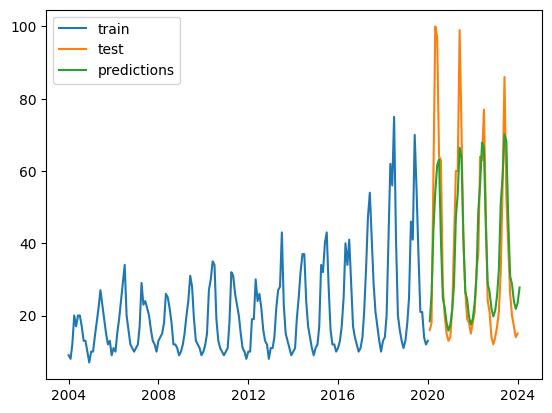

In [197]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()